 
##Assignment 2.2.2 - Automatic Relevance Determination

In this file, we conduct Automatic Relevance Determination (ARD) on one synthetic dataset and one real-world dataset.

The implementation of ARD is based on the ``python`` package ``scikit-learn``.


In [10]:
# Please first load your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Please go to the folder with all assignment files
# Please change the following path to your own path
!cd /content/drive/MyDrive/DMNN/DMNN2023

/bin/bash: line 1: cd: /content/drive/MyDrive/DMNN/DMNN2023: No such file or directory


## Synthetic dataset
In this section, we conduct ARD regression on a synthetic dataset with ``python`` package ``scikit-learn``.
We compare the weights learned by ARD and ordinary least squares (OLS) estimator, and disucss the results.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import ARDRegression, LinearRegression

In [13]:
# Generating simulated data with Gaussian weights
# Parameters of the example
np.random.seed(0)
n_samples, n_features = 100, 100
# Create Gaussian data
X = np.random.randn(n_samples, n_features)
# Create weights with a precision lambda_ of 4.
lambda_ = 4.0
w = np.zeros(n_features)
# Only keep 10 weights of interest
relevant_features = np.random.randint(0, n_features, 10)
print("Relevant feature dimensions are {}".format(relevant_features))


for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(lambda_))
# Create noise with a precision alpha of 50.
alpha_ = 50.0
noise = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(alpha_), size=n_samples)
# Create the target
y = np.dot(X, w) + noise

Relevant feature dimensions are [12 16 20 33 75 28 89 19 92 42]


We now implement ARDRegression and OLS on the dataset.

In [14]:
# Fit the ARD Regression
clf = ARDRegression(compute_score=True)
clf.fit(X, y)

ols = LinearRegression()
ols.fit(X, y)

LinearRegression()

Now, we plot the true weights, the estimated weights by ARD and OLS.
Compared to OLS, the coefficient weights of ARD are shifted toward zeros, hence bring sparseness, which also makes the regressor more stable.

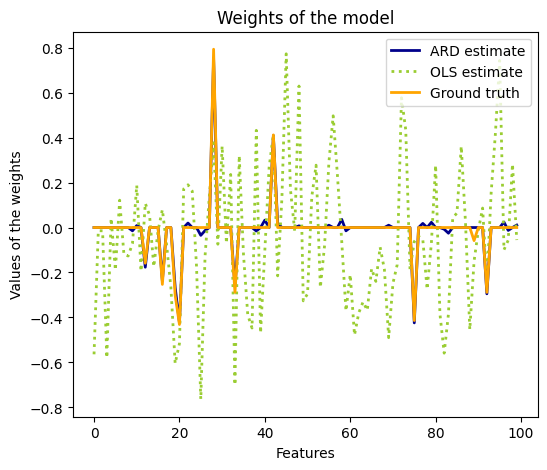

In [15]:
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color="darkblue", linestyle="-", linewidth=2, label="ARD estimate")
plt.plot(
    ols.coef_, color="yellowgreen", linestyle=":", linewidth=2, label="OLS estimate"
)
plt.plot(w, color="orange", linestyle="-", linewidth=2, label="Ground truth")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

We also plot the histogram of the estimated weights. It can be seen that the histogram is very peaked. This is due to the sparsity-inducing prior implied on the weights used in ARD.

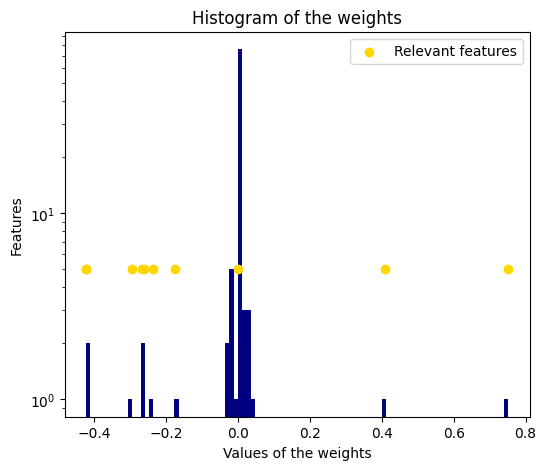

In [16]:
plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=n_features, color="navy", log=True)
plt.scatter(
    clf.coef_[relevant_features],
    np.full(len(relevant_features), 5.0),
    color="gold",
    marker="o",
    label="Relevant features",
)
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

## Real-world dataset: Diabetes dataset
In this section, we apply ARD to the real-world dataset. We first need to install the ``openml`` package for loading the dataset.
Although we consider a classification dataset, ARD regression can still be applied to it since classification can be regarded as a regression task with ``[0,1]`` as regression targets.

In [17]:
!pip install openml

In [18]:
import numpy as np
import openml
import math

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, confusion_matrix

# Load the dataset
dataset = openml.datasets.get_dataset(42608)
# Turn data into numpy array
X, _, _, _ = dataset.get_data(dataset_format="array")
# Check the data size and dimension
print(X.shape)
# Separate input and targets
y = X[:,-1]
X = X[:,:-1]

(768, 9)


/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-18-8e83b77fea45>:10: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, _, _, _ = dataset.get_data(dataset_format="array")


In [19]:
# Fit the ARD Regression
clf = ARDRegression(compute_score=True)
clf.fit(X, y)

ols = LinearRegression()
ols.fit(X, y)

LinearRegression()

The weights of ARD show how the corresponding dimensions contribute to the prediction results.
It can be seen that the ``[0, 5, 6]`` dimensions are of importance.

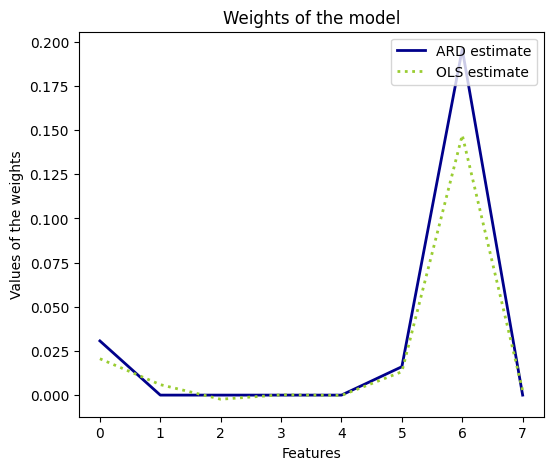

In [20]:
# Plot the true weights, the estimated weights, the histogram of the
# weights, and predictions with standard deviations
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color="darkblue", linestyle="-", linewidth=2, label="ARD estimate")
plt.plot(
    ols.coef_, color="yellowgreen", linestyle=":", linewidth=2, label="OLS estimate"
)
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

To verify if ARD shows the importance of each dimension, we conduct the following experiments where we compare the prediction results using the complete dataset and reduced dataset using only the ``[0,5,6]``-th dimensions.

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Partition dataset into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

X_train_reduce = X_train[:,[0,5,6]]
y_train_reduce = y_train
X_test_reduce = X_test[:,[0,5,6]]
y_test_reduce = y_test

In [28]:
# Define hyperparameters and dataset
hidden_layer_sizes = (50, 50, 50)
activation = 'logistic'
solver = 'adam'
max_iter = 6000

# Initialize an array to store accuracy values
accuracy_values = []

# Repeat the training and evaluation process for 100 iterations
for _ in range(100):
    # Build and train the MLP
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=max_iter)
    clf.fit(X_train, y_train)

    # Evaluate the MLP on the test set
    y_pred = clf.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)

    # Append accuracy to the list
    accuracy_values.append(acc_test)

# Compute and print the mean accuracy
mean_accuracy = np.mean(accuracy_values)
print(f"Mean accuracy over 100 iterations: {mean_accuracy:.3f}")

Mean accuracy over 100 iterations: 0.666


In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define hyperparameters and dataset for the dimension-reduced case
hidden_layer_sizes = (50, 50, 50)
activation = 'logistic'
solver = 'adam'
max_iter = 6000

# Initialize an array to store accuracy values for the dimension-reduced dataset
accuracy_values_reduce = []

# Repeat the training and evaluation process for 100 iterations on the reduced dataset
for _ in range(100):
    # Build and train the MLP on the reduced dataset
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=max_iter)
    clf.fit(X_train_reduce, y_train_reduce)

    # Evaluate the MLP on the reduced test set
    y_pred_reduce = clf.predict(X_test_reduce)
    acc_test_reduce = accuracy_score(y_test_reduce, y_pred_reduce)

    # Append accuracy to the list
    accuracy_values_reduce.append(acc_test_reduce)

# Compute and print the mean accuracy for the reduced dataset
mean_accuracy_reduce = np.mean(accuracy_values_reduce)
print(f"Mean accuracy over 100 iterations on the dimension-reduced test set: {mean_accuracy_reduce:.3f}")


Mean accuracy over 100 iterations on the dimension-reduced test set: 0.672
